In [31]:
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
from sklearn.neighbors import KNeighborsClassifier
from knn import MyKNeighborsClassifier, lowess
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from sklearn import preprocessing
import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from statistics import mean
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler

# Preprocessing

In [33]:
from ucimlrepo import fetch_ucirepo

wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes) 
X = wine_quality.data.features
Y = wine_quality.data.targets['quality']


(array([  30.,  216.,    0., 2138.,    0., 2836., 1079.,    0.,  193.,
           5.]),
 array([3. , 3.6, 4.2, 4.8, 5.4, 6. , 6.6, 7.2, 7.8, 8.4, 9. ]),
 <BarContainer object of 10 artists>)

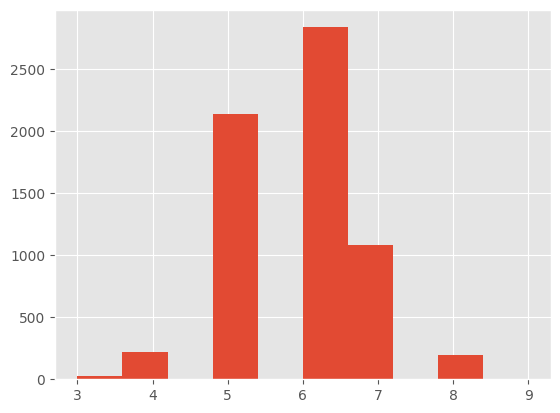

In [34]:
plt.hist(Y)

In [35]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X, Y = ros.fit_resample(X, Y)

(array([2836., 2836.,    0., 2836.,    0., 2836., 2836.,    0., 2836.,
        2836.]),
 array([3. , 3.6, 4.2, 4.8, 5.4, 6. , 6.6, 7.2, 7.8, 8.4, 9. ]),
 <BarContainer object of 10 artists>)

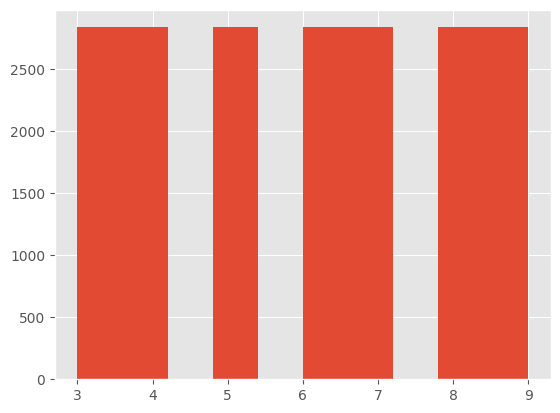

In [36]:
plt.hist(Y)


In [37]:
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
print(X)

[[0.29752066 0.41333333 0.         ... 0.6124031  0.19101124 0.20289855]
 [0.33057851 0.53333333 0.         ... 0.37209302 0.25842697 0.26086957]
 [0.33057851 0.45333333 0.02409639 ... 0.41860465 0.24157303 0.26086957]
 ...
 [0.43801653 0.12666667 0.27108434 ... 0.37209302 0.13483146 0.34782609]
 [0.43801653 0.12666667 0.27108434 ... 0.37209302 0.13483146 0.34782609]
 [0.29752066 0.10666667 0.21686747 ... 0.43410853 0.14606742 0.65217391]]


In [38]:
models = [KNeighborsClassifier, MyKNeighborsClassifier]
models_name = ['sklearn', 'my impl']

#  Hyperparamaters

[I 2024-04-04 20:49:03,388] A new study created in memory with name: no-name-a7dabd59-4f88-43c6-8445-f3cf44624676
[I 2024-04-04 20:49:11,186] Trial 4 finished with value: 0.6999798508966351 and parameters: {'n_neighbors': 18, 'metric': 'euclidean'}. Best is trial 4 with value: 0.6999798508966351.
[I 2024-04-04 20:49:19,247] Trial 0 finished with value: 0.7568674860635368 and parameters: {'n_neighbors': 9, 'metric': 'cosine'}. Best is trial 0 with value: 0.7568674860635368.
[I 2024-04-04 20:49:20,057] Trial 3 finished with value: 0.7156961515212573 and parameters: {'n_neighbors': 15, 'metric': 'cosine'}. Best is trial 0 with value: 0.7568674860635368.
[I 2024-04-04 20:49:22,385] Trial 1 finished with value: 0.7568674860635368 and parameters: {'n_neighbors': 9, 'metric': 'cosine'}. Best is trial 0 with value: 0.7568674860635368.
[I 2024-04-04 20:49:23,102] Trial 2 finished with value: 0.7044126536369132 and parameters: {'n_neighbors': 17, 'metric': 'cosine'}. Best is trial 0 with value: 

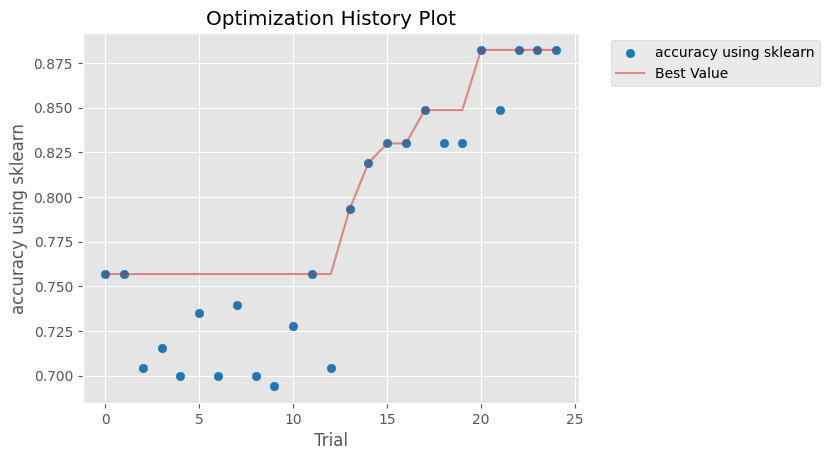

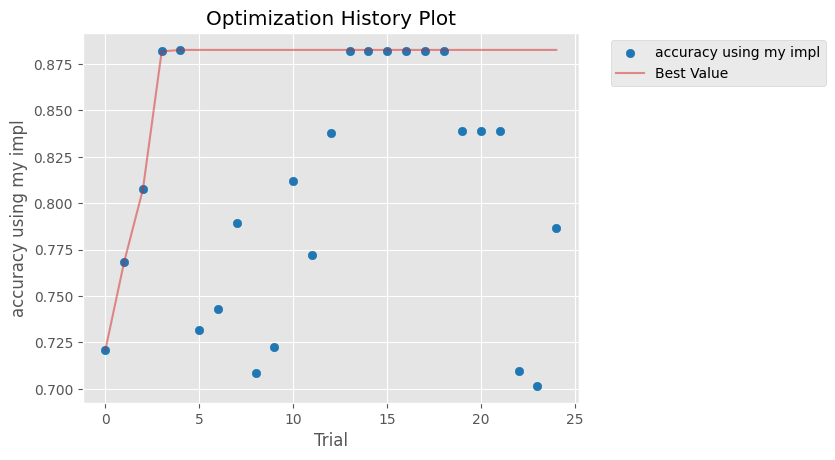

In [39]:

def train_all(trial, model):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)
    n = trial.suggest_int("n_neighbors", 1, 20)
    m = trial.suggest_categorical("metric", ['euclidean', 'cosine', 'manhattan'])
    if model is MyKNeighborsClassifier:
        k = trial.suggest_categorical('kernel',
                                      ['uniform_kernel', 'gaussian_kernel', 'triungular_kernel', 'epachnikov_kernel'])
        fixed = trial.suggest_categorical('is_fixed_window', [True, False])
        clf = model(n_neighbors=n, metric=m, kernel=k, is_fixed_window=fixed)
        if (fixed):
            h = trial.suggest_float("h", 1, n)
            clf.h = h
        else:
            k = trial.suggest_int("k", 1, n)
            clf.k = k
    else:
        clf = model(n_neighbors=n, metric=m)
    clf.fit(x_train, y_train)
    return mean(cross_val_score(clf, x_train, y_train, cv=3, scoring='accuracy'))

bmods = []
for mod, name in zip(models, models_name):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: train_all(trial, mod), n_trials=25, n_jobs=5)
    plot_optimization_history(study, target_name=f'accuracy using {name}')
    bmods.append(study.best_params)


[I 2024-04-04 20:55:41,646] A new study created in memory with name: no-name-e09ff8d8-26ff-4d32-b8c9-2c8007537ceb
[I 2024-04-04 20:55:43,237] Trial 0 finished with value: 0.681375276267367 and parameters: {'n_neighbors': 25}. Best is trial 0 with value: 0.681375276267367.
[I 2024-04-04 20:55:44,826] Trial 1 finished with value: 0.6763377747417914 and parameters: {'n_neighbors': 27}. Best is trial 0 with value: 0.681375276267367.
[I 2024-04-04 20:55:46,221] Trial 2 finished with value: 0.727046442695995 and parameters: {'n_neighbors': 16}. Best is trial 2 with value: 0.727046442695995.
[I 2024-04-04 20:55:47,828] Trial 3 finished with value: 0.6684795430740219 and parameters: {'n_neighbors': 29}. Best is trial 2 with value: 0.727046442695995.
[I 2024-04-04 20:55:49,323] Trial 4 finished with value: 0.6978299264587944 and parameters: {'n_neighbors': 21}. Best is trial 2 with value: 0.727046442695995.
[I 2024-04-04 20:55:50,909] Trial 5 finished with value: 0.6731137963247671 and paramete

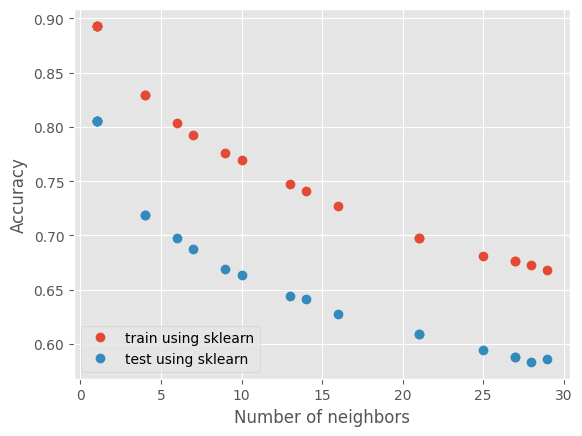

[I 2024-04-04 20:56:06,737] A new study created in memory with name: no-name-a2ebea4d-633c-4134-a9e4-1f919717621d
[I 2024-04-04 20:56:13,472] Trial 0 finished with value: 0.7842701138547534 and parameters: {'n_neighbors': 9}. Best is trial 0 with value: 0.7842701138547534.
[I 2024-04-04 20:56:20,496] Trial 1 finished with value: 0.7699642863024401 and parameters: {'n_neighbors': 11}. Best is trial 0 with value: 0.7842701138547534.
[I 2024-04-04 20:56:25,940] Trial 2 finished with value: 0.8927397939835583 and parameters: {'n_neighbors': 2}. Best is trial 2 with value: 0.8927397939835583.
[I 2024-04-04 20:56:32,861] Trial 3 finished with value: 0.779770156379117 and parameters: {'n_neighbors': 10}. Best is trial 2 with value: 0.8927397939835583.
[I 2024-04-04 20:56:38,508] Trial 4 finished with value: 0.8527774049219525 and parameters: {'n_neighbors': 3}. Best is trial 2 with value: 0.8927397939835583.
[I 2024-04-04 20:56:45,484] Trial 5 finished with value: 0.7842701138547534 and param

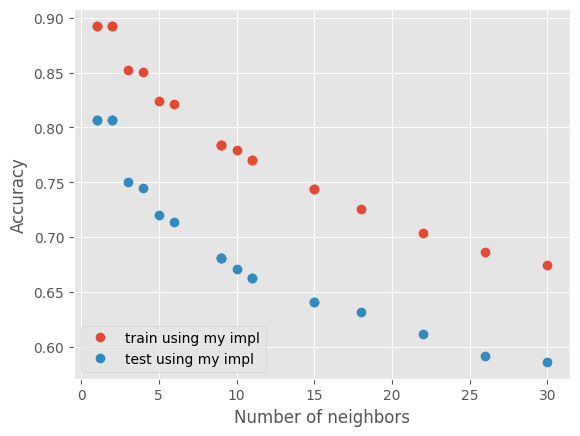

In [40]:

out = ([], [])
ind = []


def train_neighbors(trial, model):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=8)
    n = trial.suggest_int("n_neighbors", low=1, high=30)
    ind.append(n)
    clf = model(n_neighbors=n, metric="minkowski")
    clf.fit(x_train, y_train)
    res = mean(cross_val_score(clf, x_train, y_train, cv=5, scoring='accuracy'))
    out[0].append(res)
    out[1].append(mean(cross_val_score(clf, x_test, y_test, cv=5, scoring='accuracy')))
    return res


for mod, name in zip(models, models_name):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: train_neighbors(trial, mod), n_trials=20)
    plt.plot(ind, out[0], 'o', label=f'train using {name}')
    plt.plot(ind, out[1], 'o', label=f'test using {name}')
    plt.legend(loc="lower left")
    plt.xlabel("Number of neighbors")
    plt.ylabel("Accuracy")
    plt.show()
    out = ([], [])
    ind.clear()

In [41]:
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)


[I 2024-04-04 21:00:08,276] A new study created in memory with name: no-name-3e30a7af-1245-443c-bdbe-91e78a2c4355
/home/nikkirche/Homework/sem5/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
[I 2024-04-04 21:00:10,462] Trial 0 finished with value: 0.8343202222603058 and parameters: {'weight': 5.4}. Best is trial 0 with value: 0.8343202222603058.
/home/nikkirche/Homework/sem5/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
[I 2024-04-04 21:00:12,543] Trial 1 finished with value: 0.8345056774875778 and parameters: {'weight': 5.7}. Best is trial 1 with value: 0.8345056774875778.
/home/nikkirche/Homework/sem5/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not 

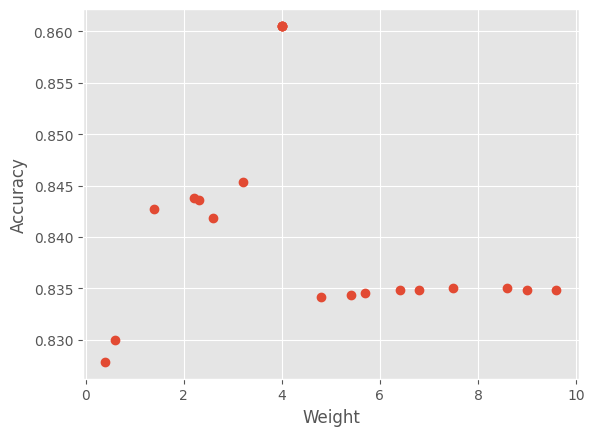

1960


In [46]:

from sklearn.metrics import balanced_accuracy_score
from optuna import create_study
isf = bmods[1]['is_fixed_window']
best_mod = MyKNeighborsClassifier(n_neighbors=5, metric=bmods[1]['metric'], kernel=bmods[1]['kernel'], 
is_fixed_window = isf)
if(isf):
    best_mod.h = bmods[1]['h']
else:
    best_mod.k = bmods[1]['k']
arr = ([], [])


def check_weight(trial, anomalies):
    w = trial.suggest_float("weight", low=0, high=10, step=0.1)
    wr = [1 for _ in range(len(x_train))]
    for i in anomalies:
        wr[i] = w
    m = MyKNeighborsClassifier(n_neighbors=5, metric=bmods[1]['metric'], kernel=bmods[1]['kernel'], weights=wr,
                               is_fixed_window=bmods[1]['is_fixed_window'])
    if(isf):
        best_mod.h = bmods[1]['h']
    else:
        best_mod.k = bmods[1]['k']
    m.fit(x_train, y_train)
    arr[0].append(w)
    p = balanced_accuracy_score(y_test, m.predict(x_test))
    arr[1].append(p)
    return p


anom = lowess(best_mod, x_train, y_train)
study = create_study(direction='maximize')
study.optimize(lambda trial: check_weight(trial, anom), n_trials=20)
plt.plot(arr[0], arr[1], 'o', label='with using of lowess')
plt.xlabel("Weight")
plt.ylabel("Accuracy")
plt.show()
print(len(anom))

In [51]:
bmods[1]

{'n_neighbors': 1,
 'metric': 'manhattan',
 'kernel': 'uniform_kernel',
 'is_fixed_window': True,
 'h': 1.0}

In [49]:
best_mod.fit(x_train, y_train)
print(f'before it was {balanced_accuracy_score(y_test, best_mod.predict(x_test))}')

before it was 0.840921845900928


/home/nikkirche/Homework/sem5/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [50]:
print(
    f'In library before it was {balanced_accuracy_score(y_test, KNeighborsClassifier(n_neighbors=10, metric=bmods[1]["metric"]).fit(x_train, y_train).predict(x_test))} after {balanced_accuracy_score(y_test, KNeighborsClassifier(n_neighbors=10, weights="distance", metric=bmods[1]["metric"]).fit(x_train, y_train).predict(x_test))}')

In library before it was 0.7898181765148575 after 0.8871647336512211
